### **1. Import Necessary Library**

In [7]:
!pip install -q seaborn

from sklearn import preprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, RepeatVector, TimeDistributed, Activation
from keras.optimizers import Adadelta, Adam, SGD
from keras import Sequential, layers, callbacks, backend as K

np.set_printoptions(precision=3, suppress=True)
pd.options.mode.chained_assignment = None

### **2. Load Raw Dataset**
The datased was Scrapped from NERD website (https://nerd.cesnet.cz/nerd/ips/)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%cd "drive/MyDrive/Disertasi/Regresi/dataset/"

/content/drive/MyDrive/Disertasi/Regresi/dataset


In [5]:
dataset = pd.read_csv('nerd_warden_merged.csv')

dataset["country"].fillna("None", inplace = True)
dataset["event_categories"].fillna("None", inplace = True)
dataset["blacklists"].fillna("None", inplace = True)
dataset["tags"].fillna("None", inplace = True)
dataset.isnull().any()

ip                    False
hostname              False
asn                   False
country               False
events                False
event_nodes           False
event_categories_c    False
event_categories      False
rep_score             False
blacklists            False
tags                  False
ts_added              False
ts_last_event         False
dtype: bool

### **3. Dataset Preprocessing**
This Process includes:
*   Create additional features: `blacklist_c`, `blacklist_w`, `event_categories_w`, `tags_c`, `tags_w`
*   Invert the reputation score
*   Encode the data using Mean Encoding
*   Inspect the data
*   Normalize the data using `tf.keras.layers.Normalization`





##### 3a. Create additional features

In [ ]:
# Convert NaN to empty string in blacklists row
for i in range(len(dataset)):
  if isinstance(dataset['blacklists'][i], float):
    dataset['blacklists'][i] = ''

# Create blacklist dictionary
blacklist_dict = {}
total_blacklist = 0
for i in range(len(dataset)):
  current_list = dataset['blacklists'][i].split("|")
  for j in range(len(current_list)):
    if (current_list[j] not in blacklist_dict) and (current_list[j] != ''):
      blacklist_dict[current_list[j]] = 1
      total_blacklist += 1
    elif (current_list[j] in blacklist_dict):
      blacklist_dict[current_list[j]] += 1
      total_blacklist += 1

print('Found ' + str(len(blacklist_dict)) + ' items for blacklist dictionary. with total blacklist = ' + str(total_blacklist))

# put blacklist weight and count into dataset
dataset['blacklists_c'] = ''
dataset['blacklists_w'] = ''

for i in tqdm(range(len(dataset))): 
  current_list = dataset['blacklists'][i].split("|")
  current_weight = 0
  current_count = 0
  for j in range(len(current_list)):
    if current_list[j] in blacklist_dict:
      current_weight += blacklist_dict[current_list[j]]
      current_count += 1
  dataset['blacklists_w'][i] = current_weight/total_blacklist
  dataset['blacklists_c'][i] = current_count

Found 61 items for blacklist dictionary. with total blacklist = 717291


  0%|          | 0/141069 [00:00<?, ?it/s]

In [ ]:
# Convert NaN to empty string in event_categories row
for i in range(len(dataset)):
  if isinstance(dataset['event_categories'][i], float):
    dataset['event_categories'][i] = ''

# Create event_categories dictionary
event_categories_dict = {}
total_event_categories = 0
for i in range(len(dataset)):
  current_list = dataset['event_categories'][i].split("|")
  for j in range(len(current_list)):
    if (current_list[j] not in event_categories_dict) and (current_list[j] != ''):
      event_categories_dict[current_list[j]] = 1
      total_event_categories += 1
    elif (current_list[j] in event_categories_dict):
      event_categories_dict[current_list[j]] += 1
      total_event_categories += 1

print('Found ' + str(len(event_categories_dict)) + ' items for event categories dictionary. with total event categories = ' + str(total_event_categories))

# put event_categories weight into dataset
dataset['event_categories_w'] = ''

for i in tqdm(range(len(dataset))): 
  current_list = dataset['event_categories'][i].split("|")
  current_weight = 0
  for j in range(len(current_list)):
    if current_list[j] in event_categories_dict:
      current_weight += event_categories_dict[current_list[j]]
  dataset['event_categories_w'][i] = current_weight/total_event_categories

Found 12 items for event categories dictionary. with total event categories = 216959


  0%|          | 0/141069 [00:00<?, ?it/s]

In [ ]:
# Convert NaN to empty string in tags row
for i in range(len(dataset)):
  if isinstance(dataset['tags'][i], float):
    dataset['tags'][i] = ''

# Create tags dictionary
tags_dict = {}
total_tags = 0
for i in range(len(dataset)):
  current_list = dataset['tags'][i].split("|")
  for j in range(len(current_list)):
    if (current_list[j] not in tags_dict) and (current_list[j] != ''):
      tags_dict[current_list[j]] = 1
      total_tags += 1
    elif (current_list[j] in tags_dict):
      tags_dict[current_list[j]] += 1
      total_tags += 1

print('Found ' + str(len(tags_dict)) + ' items for tags dictionary. with total tags = ' + str(total_tags))

# put event_categories weight into dataset
dataset['tags_w'] = ''
dataset['tags_c'] = ''

for i in tqdm(range(len(dataset))): 
  current_list = dataset['tags'][i].split("|")
  current_weight = 0
  current_count = 0
  for j in range(len(current_list)):
    if current_list[j] in tags_dict:
      current_weight += tags_dict[current_list[j]]
      current_count += 1
  dataset['tags_w'][i] = current_weight/total_tags
  dataset['tags_c'][i] = current_count

Found 14 items for tags dictionary. with total tags = 210158


  0%|          | 0/141069 [00:00<?, ?it/s]

##### 3b. Invert the reputation score

In [ ]:
# inverse reputation score
dataset['inv_rep_score'] = ''
for i in tqdm(range(len(dataset))):
  dataset['inv_rep_score'] = 1 - dataset['rep_score']
  dataset['inv_rep_score'].astype(float)

  0%|          | 0/141069 [00:00<?, ?it/s]

In [ ]:
dataset_slim = dataset[['ip', 'hostname', 'asn', 'country', 'events', 'event_nodes', 'event_categories_c', 'event_categories_w', 'blacklists_c', 'blacklists_w', 'tags_c', 'tags_w', 'inv_rep_score']]

dataset_slim['event_categories_w'] = dataset_slim['event_categories_w'] .astype(float)
dataset_slim['blacklists_c'] = dataset_slim['blacklists_c'] .astype(float)
dataset_slim['blacklists_w'] = dataset_slim['blacklists_w'] .astype(float)
dataset_slim['tags_c'] = dataset_slim['tags_c'] .astype(float)
dataset_slim['tags_w'] = dataset_slim['tags_w'] .astype(float)
dataset_slim['inv_rep_score'] = dataset_slim['inv_rep_score'] .astype(float)
print(dataset_slim.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141069 entries, 0 to 141068
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ip                  141069 non-null  object 
 1   hostname            141069 non-null  object 
 2   asn                 141069 non-null  object 
 3   country             141069 non-null  object 
 4   events              141069 non-null  int64  
 5   event_nodes         141069 non-null  int64  
 6   event_categories_c  141069 non-null  int64  
 7   event_categories_w  141069 non-null  float64
 8   blacklists_c        141069 non-null  float64
 9   blacklists_w        141069 non-null  float64
 10  tags_c              141069 non-null  float64
 11  tags_w              141069 non-null  float64
 12  inv_rep_score       141069 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 14.0+ MB
None


##### 3c. Encode the data using Mean Encoding
Further reads of Mean Encoding:
*   https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
*   https://www.kdnuggets.com/2021/05/deal-with-categorical-data-machine-learning.html

In [ ]:
# Encode by Mean
mean_ip_address = dataset_slim.groupby(['ip'])['inv_rep_score'].mean().to_dict()
dataset_slim['ip'] =  dataset_slim['ip'].map(mean_ip_address)

mean_hostname = dataset_slim.groupby(['hostname'])['inv_rep_score'].mean().to_dict()
dataset_slim['hostname'] =  dataset_slim['hostname'].map(mean_hostname)

mean_asn = dataset_slim.groupby(['asn'])['inv_rep_score'].mean().to_dict()
dataset_slim['asn'] =  dataset_slim['asn'].map(mean_asn)

mean_country = dataset_slim.groupby(['country'])['inv_rep_score'].mean().to_dict()
dataset_slim['country'] =  dataset_slim['country'].map(mean_country)

##### 3d. Inspect the data

In [ ]:
# Split the data into training and test sets
train_dataset = dataset_slim.sample(frac=0.9, random_state=42)
test_dataset = dataset_slim.drop(train_dataset.index)

In [ ]:
dataset_slim.tail()
dataset_slim.isnull().any()

ip                    False
hostname              False
asn                   False
country               False
events                False
event_nodes           False
event_categories_c    False
event_categories_w    False
blacklists_c          False
blacklists_w          False
tags_c                False
tags_w                False
inv_rep_score         False
dtype: bool

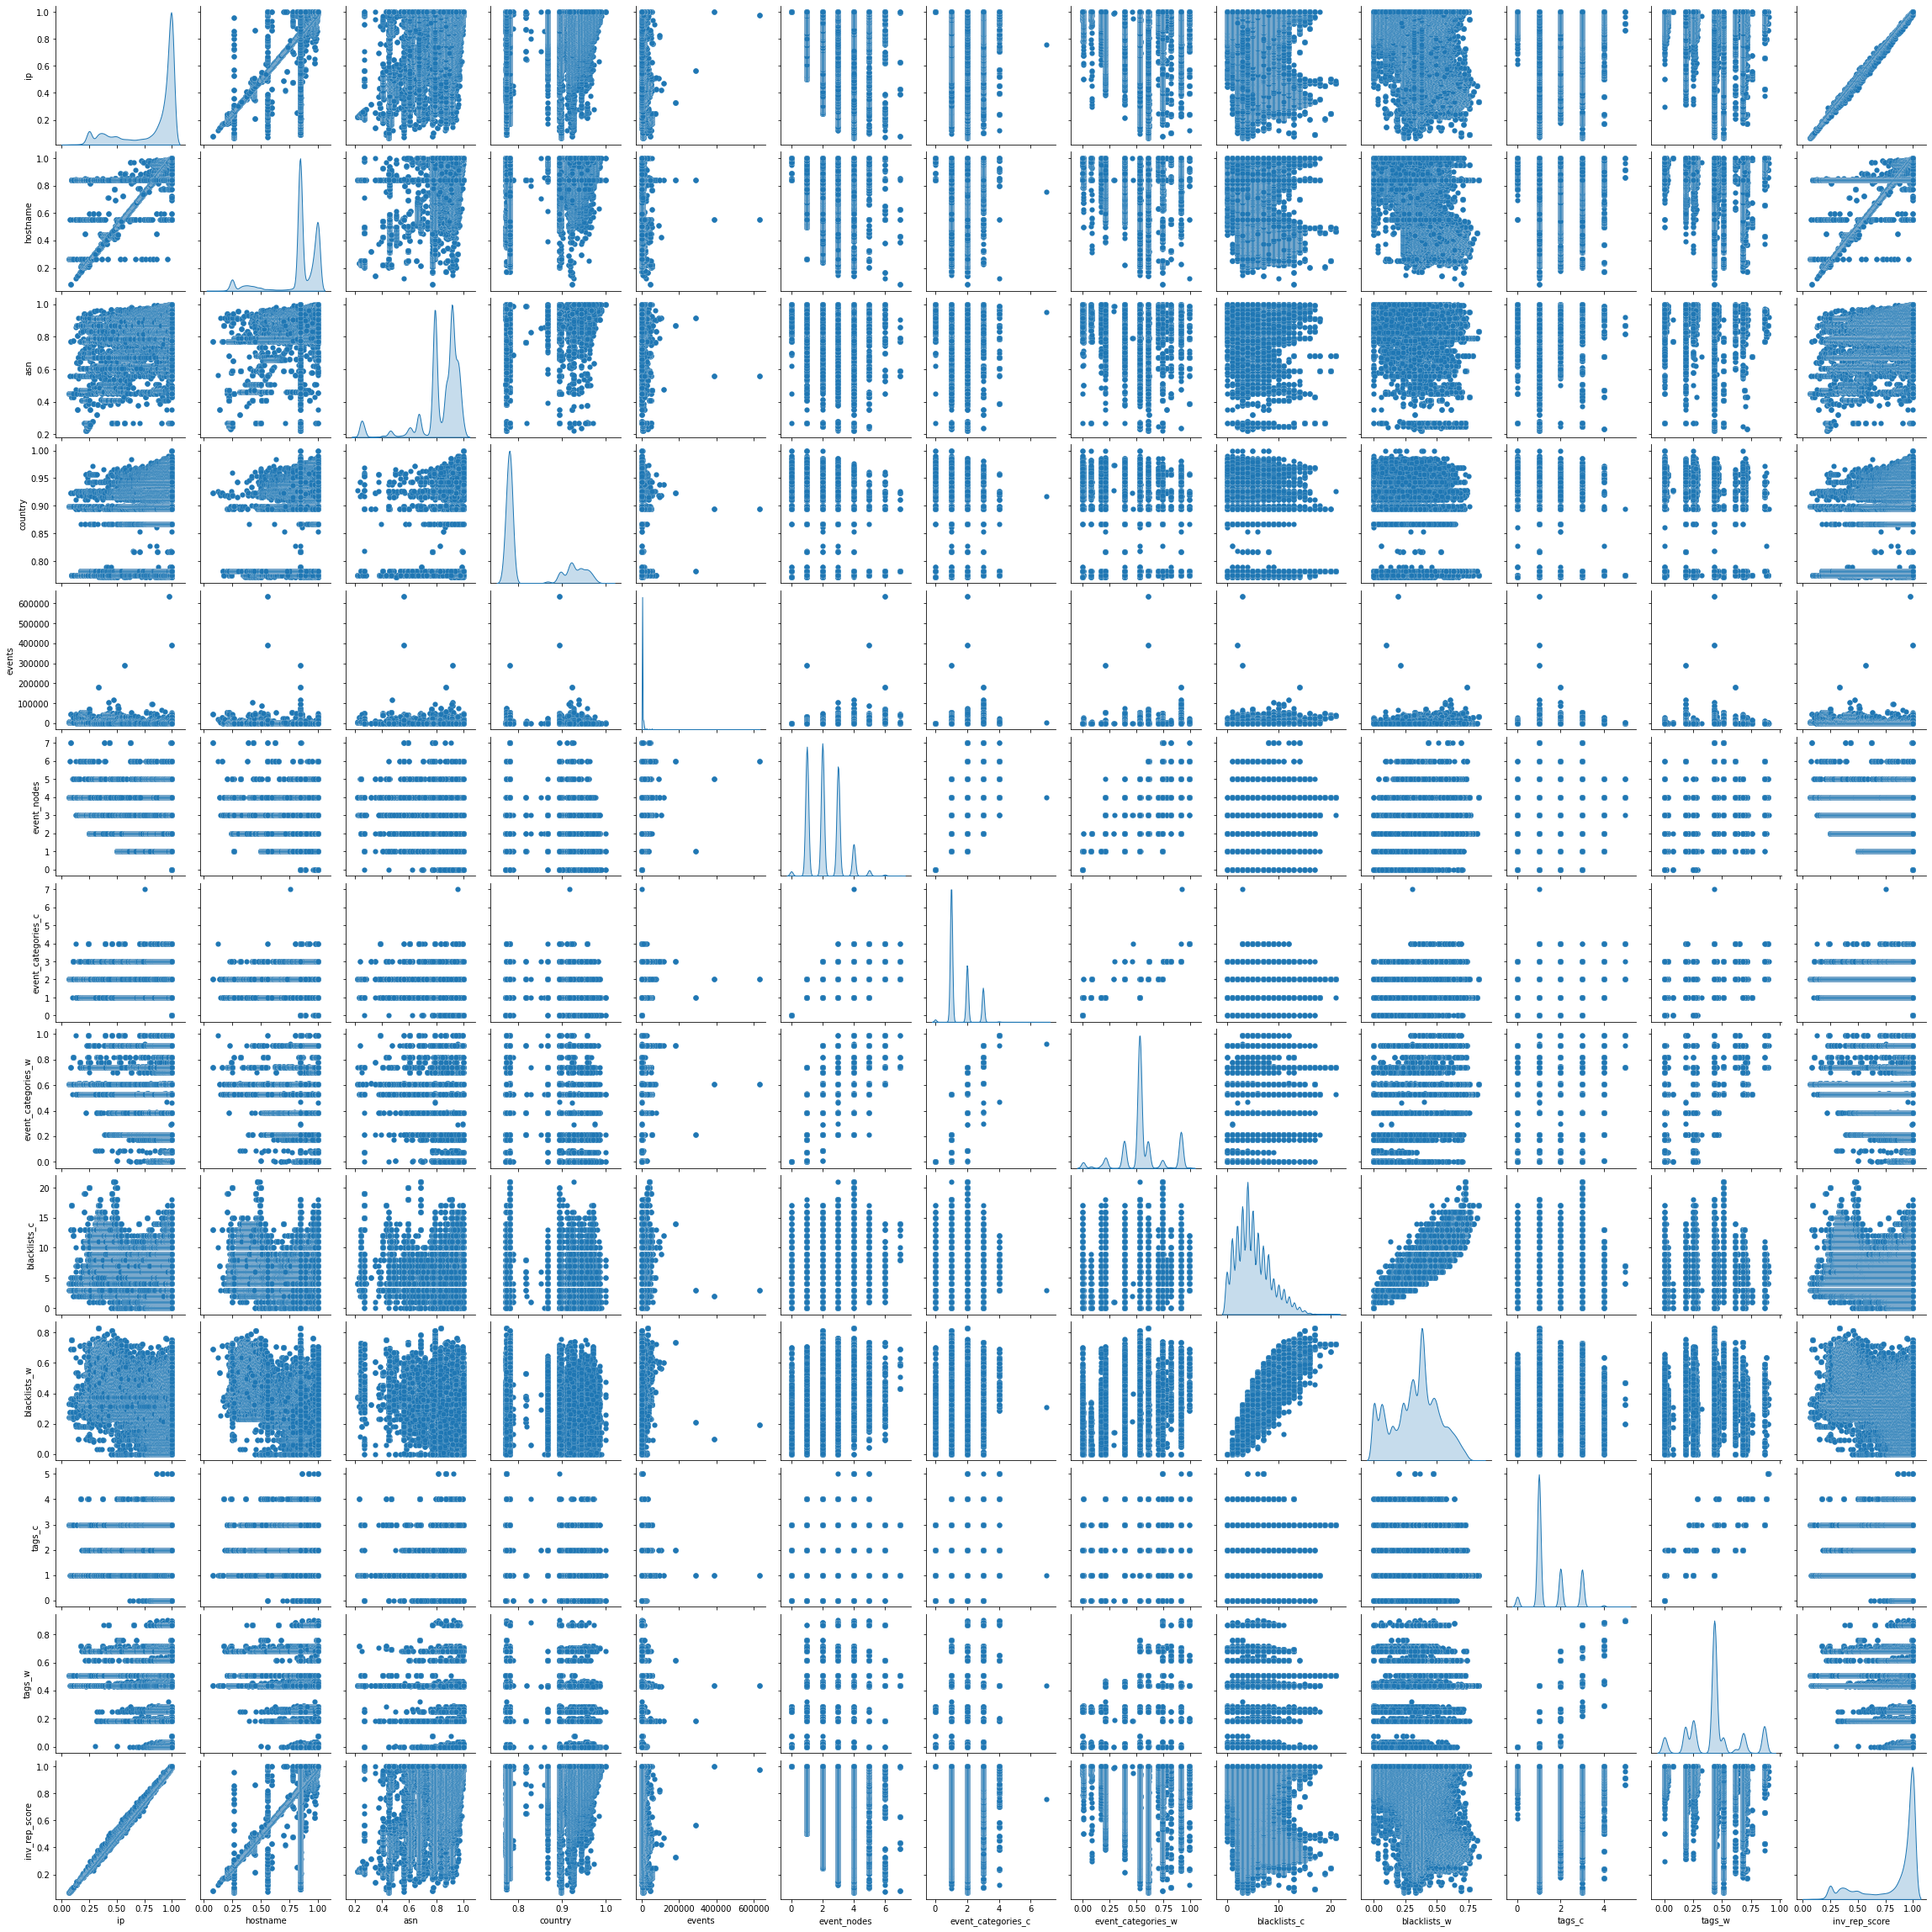

In [ ]:
# Review the joint distribution of a few pairs of columns from the training set.
# The top row suggests that the Reputation is a function of all the other features. The other rows indicate they are functions of each other.

sns.pairplot(dataset_slim[['ip', 'hostname', 'asn', 'country', 'events', 'event_nodes', 'event_categories_c', 'event_categories_w', 'blacklists_c', 'blacklists_w', 'tags_c', 'tags_w', 'inv_rep_score']], diag_kind='kde', plot_kws=dict(linewidth=0.3, s=50))

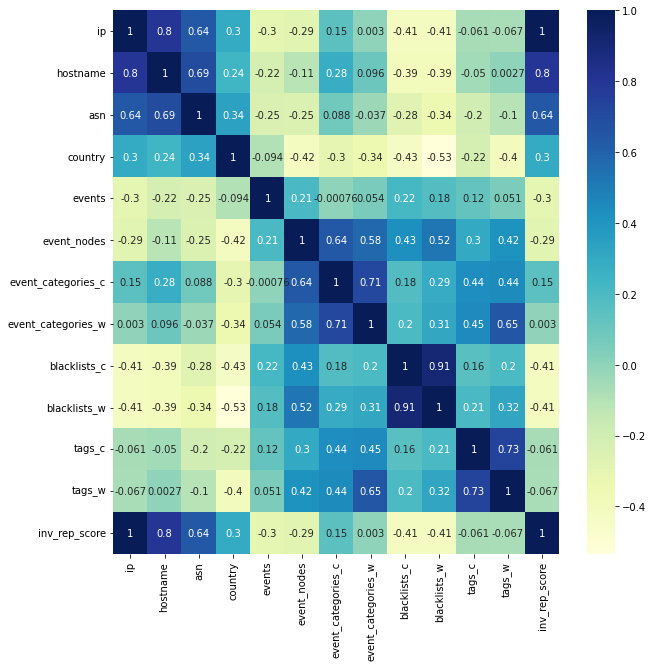

In [ ]:
# plotting correlation heatmap
fig, ax = plt.subplots(figsize=(10,10))
dataplot = sns.heatmap(dataset_slim.corr(), cmap="YlGnBu", annot=True, ax=ax)
  
# displaying heatmap
plt.show()

In [ ]:
# Let's also check the overall statistics. Note how each feature covers a very different range (esp events)
train_dataset.describe().transpose()

count         mean          std       min        25%  \
ip                  126962.0     0.828874     0.243710  0.064293   0.750000   
hostname            126962.0     0.828631     0.195476  0.079167   0.840939   
asn                 126962.0     0.828553     0.156616  0.221129   0.789926   
country             126962.0     0.828468     0.072144  0.771206   0.781819   
events              126962.0  1420.575834  6305.861395  0.000000  20.000000   
event_nodes         126962.0     2.138585     1.037314  0.000000   1.000000   
event_categories_c  126962.0     1.538153     0.759570  0.000000   1.000000   
event_categories_w  126962.0     0.554199     0.196099  0.000000   0.528533   
blacklists_c        126962.0     5.085041     3.312932  0.000000   3.000000   
blacklists_w        126962.0     0.331513     0.183023  0.000000   0.208663   
tags_c              126962.0     1.490501     0.850971  0.000000   1.000000   
tags_w              126962.0     0.427537     0.211953  0.000000   0.248389   
inv_rep_score       126962.0     0.828871     0.243732  0.064293   0.750011   

                           50%         75%            max  
ip                    0.957145    1.000000       1.000000  
hostname              0.840939    0.971429       1.000000  
asn                   0.878336    0.916450       1.000000  
country               0.781819    0.915761       1.000000  
events              134.000000  692.000000  633256.000000  
event_nodes           2.000000    3.000000       7.000000  
event_categories_c    1.000000    2.000000       7.000000  
event_categories_w    0.528533    0.605764       0.990556  
blacklists_c          5.000000    7.000000      21.000000  
blacklists_w          0.359476    0.463983       0.831982  
tags_c                1.000000    2.000000       5.000000  
tags_w                0.433474    0.447387       0.901950  
inv_rep_score         0.957145    1.000000       1.000000

In [ ]:
# Separate the target value (label) from the features. This label is the value that you will train the model to predict.

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('inv_rep_score')
test_labels = test_features.pop('inv_rep_score')

##### 3e. Normalize the data using `tf.keras.layers.Normalization`

In the table of statistics it's easy to see how different the ranges of each feature are. 

It is good practice to normalize features that use different scales and ranges. One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

mean          std
ip                     0.828874     0.243710
hostname               0.828631     0.195476
asn                    0.828553     0.156616
country                0.828468     0.072144
events              1420.575834  6305.861395
event_nodes            2.138585     1.037314
event_categories_c     1.538153     0.759570
event_categories_w     0.554199     0.196099
blacklists_c           5.085041     3.312932
blacklists_w           0.331513     0.183023
tags_c                 1.490501     0.850971
tags_w                 0.427537     0.211953
inv_rep_score          0.828871     0.243732

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [ ]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [ ]:
print(normalizer.mean.numpy())

[[   0.829    0.829    0.829    0.828 1420.575    2.139    1.538    0.554
     5.085    0.332    1.491    0.428]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('Before normalization:')
  print(np.vstack(first))
  print('\nNormalized:')
  print(np.vstack(normalizer(first).numpy()))

Before normalization:
[[ 0.98  0.98  0.91  0.92 51.    1.    1.    0.53  2.    0.18  2.    0.68]]

Normalized:
[[ 0.6   0.75  0.54  1.31 -0.22 -1.1  -0.71 -0.13 -0.93 -0.81  0.6   1.2 ]]


### **4. Model Creation & Training: BiLSTM - GRU - LSTM** 

In [ ]:
test_results = {}

# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

# Loss Function
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

  model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(0.001))
  return model

# Create BiLSTM model
def create_model_bidirection(units, m):
    model = Sequential()
    # model.add(Bidirectional(m (units = units, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    forward_layer = m(units = units, return_sequences=True)
    backward_layer = m(units = units, return_sequences=True, go_backwards=True)
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1))
    #Compile model
    model.compile(loss=root_mean_squared_error, optimizer = Adadelta(clipnorm=0.25))
    return model

# Create LSTM or GRU model
def create_model_unidirection(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1))
    #Compile model
    model.compile(loss=root_mean_squared_error, optimizer = Adadelta(clipnorm=0.25))
    return model

# Fit models
def fit_model(model):
    history = model.fit(X_train, y_train, epochs = 100, verbose = 0  
                        validation_split = 0.2, batch_size = 12, 
                        shuffle = False)
    return history

# BiLSTM & BiGRU
model_bilstm = create_model_bidirection(6, LSTM)
model_bigru = create_model_bidirection(6, GRU)

# UniLSTM & UniGRU
model_lstm = create_model_unidirection(6, LSTM)
model_gru = create_model_unidirection(6, GRU)

In [ ]:
dataset_shuffle = dataset_slim.sample(frac=1).reset_index(drop=True)
X = dataset_shuffle[['ip', 'hostname', 'asn', 'country', 'events', 'event_nodes', 'event_categories_c', 'event_categories_w', 'blacklists_c', 'blacklists_w', 'tags_c', 'tags_w']]
y = dataset_shuffle[['inv_rep_score']]

X_train, y_train = create_dataset(X, y['inv_rep_score'])

In [ ]:
print('TRAINING BIDIRECTIONAL MODELS')
print('- BiLSTM')
history_bilstm = fit_model(model_bilstm)
print('\n- BiGRU')
history_bigru = fit_model(model_bigru)

print('\nTRAINING UNIDIRECTIONAL MODELS')
print('- UniLSTM')
history_lstm = fit_model(model_lstm)
print('\n- UniGRU')
history_gru = fit_model(model_gru)

### **5. Model Save** 

In [ ]:
model_bilstm.save('poir_model')